In [27]:
# Import all relevant libraries
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import Permute, Flatten, Softmax, Dense, Conv1D, Conv2D, Conv2DTranspose, AveragePooling2D, Activation, Reshape, Dropout, LSTM, GRU

# Other
import numpy as np
import h5py
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import matplotlib.pyplot as plt

# random seed for reproducability
np.random.seed(1)

In [38]:
# Load data from specific trial
def get_trial(trial_num):    
    trial = h5py.File('../data/A0' + str(trial_num) + 'T_slice.mat', 'r')
    X = np.copy(trial['image'])
    y = np.copy(trial['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    y -= 769                            # shift class labels to [0-3]
    X = np.nan_to_num(X)[:, :22, :]     # remove EOG channels
    return X, y

def get_all_trials():
    X_total = np.concatenate([get_trial(trial_num)[0] for trial_num in range(1, 9)], axis=0)
    y_total = np.concatenate([get_trial(trial_num)[1] for trial_num in range(1, 9)], axis=0)
    return X_total, y_total

def stratified_train_test_split(X, y, k, num_trials):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    sss = StratifiedShuffleSplit(n_splits=k, test_size=50*num_trials)
    return sss.split(X, y)

def generate_crops(X, y):
    '''Crop the 4s trial into 2s crops at 0.1s intervals
    (1000 timesteps > 500 timesteps, in 25 timestep intervals)
    '''
    new_X = []
    new_y = []
    for k in range(X.shape[0]):
        for i in range(20):
            new_X.append(X[(25*i):(25*i + 500)])
            new_y.append(y[i])
    return np.array(new_X), np.array(new_y)

In [ ]:
num_folds = 5

# Get the data from one person
# X, y = get_trial(2)
# num_trials = 1

# Get the data from all the people
X, y = get_all_trials()
num_trials = 9


# Generate crops
X, y = generate_crops(X, y)

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_9 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1000, 128)         77312     
_________________________________________________________________
flatten_10 (Flatten)         (None, 128000)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               25600200  
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 804       
Total params: 25,678,316
Trainable params: 25,678,316
Non-trainable params: 0
________________________________________________________________

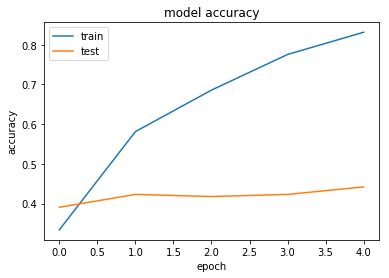

450/450 [==============================] - 4s 10ms/step
[1.3122327020433213, 0.4222222222222222]
0.08444444444444445


In [30]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and some dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)

This previous example overfit pretty badly, so we'll try removing the dense layers.

In [36]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and no dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)

ValueError: test_size=450 should be smaller than the number of samples 20

In [ ]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - 3 layers
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)

In [ ]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - 3 layers, with dropout
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)

In [ ]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - many layers, with dropout
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)

In [ ]:
# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # GRU layers
    model.add(GRU(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(GRU(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    model.add(GRU(64, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)